In [2]:
%pip install langgraph==0.3.31 
%pip install langchain-ibm==0.3.10
%pip install langchain==0.3.23
%pip install langchain_community==0.3.21 
%pip install pygraphviz==1.14

Note: you may need to restart the kernel to use updated packages.
  Using cached langchain_ibm-0.3.10-py3-none-any.whl.metadata (5.2 kB)
  Using cached ibm_watsonx_ai-1.3.36-py3-none-any.whl.metadata (7.0 kB)
  Using cached ibm_cos_sdk-2.14.3-py3-none-any.whl
  Using cached ibm_cos_sdk_core-2.14.3-py3-none-any.whl
  Using cached ibm_cos_sdk_s3transfer-2.14.3-py3-none-any.whl
Using cached langchain_ibm-0.3.10-py3-none-any.whl (28 kB)
Using cached ibm_watsonx_ai-1.3.36-py3-none-any.whl (1.2 MB)
Note: you may need to restart the kernel to use updated packages.
  Using cached langchain-0.3.23-py3-none-any.whl.metadata (7.8 kB)
  Using cached langchain_text_splitters-0.3.10-py3-none-any.whl.metadata (1.9 kB)
  Using cached langsmith-0.3.45-py3-none-any.whl.metadata (15 kB)
  Using cached pip-25.2-py3-none-any.whl.metadata (4.7 kB)
Using cached langchain-0.3.23-py3-none-any.whl (1.0 MB)
Using cached langchain_text_splitters-0.3.10-py3-none-any.whl (34 kB)
Using cached langsmith-0.3.45-py3-no

In [1]:
from langchain_ibm import ChatWatsonx
from langchain_core.messages import BaseMessage, HumanMessage
from langgraph.graph import END, MessageGraph, StateGraph

from typing import List, Sequence
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder

In [2]:
llm = ChatWatsonx(
    model_id="ibm/granite-3-3-8b-instruct",
    url="https://us-south.ml.cloud.ibm.com",
    project_id="skills-network"
)

In [3]:
generation_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are a professional LinkedIn content assistant tasked with crafting engaging, insightful, and well-structured LinkedIn posts."
            " Generate the best LinkedIn post possible for the user's request."
            " If the user provides feedback or critique, respond with a refined version of your previous attempts, improving clarity, tone, or engagement as needed.",
        ),
        MessagesPlaceholder(variable_name="messages"),
    ]
)

In [4]:
generate_chain = generation_prompt | llm

In [5]:
reflection_prompt = ChatPromptTemplate.from_messages([
    (
        "system",
        """You are a professional LinkedIn content strategist and thought leadership expert. Your task is to critically evaluate the given LinkedIn post and provide a comprehensive critique. Follow these guidelines:

        1. Assess the post’s overall quality, professionalism, and alignment with LinkedIn best practices.
        2. Evaluate the structure, tone, clarity, and readability of the post.
        3. Analyze the post’s potential for engagement (likes, comments, shares) and its effectiveness in building professional credibility.
        4. Consider the post’s relevance to the author’s industry, audience, or current trends.
        5. Examine the use of formatting (e.g., line breaks, bullet points), hashtags, mentions, and media (if any).
        6. Evaluate the effectiveness of any call-to-action or takeaway.

        Provide a detailed critique that includes:
        - A brief explanation of the post’s strengths and weaknesses.
        - Specific areas that could be improved.
        - Actionable suggestions for enhancing clarity, engagement, and professionalism.

        Your critique will be used to improve the post in the next revision step, so ensure your feedback is thoughtful, constructive, and practical.
        """
    ),
    MessagesPlaceholder(variable_name="messages")
])

In [6]:
reflect_chain = reflection_prompt | llm

In [7]:
from typing import List, Annotated, TypedDict
from langchain.schema import HumanMessage, AIMessage, SystemMessage

# Define State with TypedDict
class AgentState(TypedDict):
    messages: Annotated[List[HumanMessage | AIMessage | SystemMessage], "add_messages"]

In [8]:
from langgraph.graph import MessageGraph


# Initialize a predefined MessageGraph
graph = MessageGraph()

In [9]:
def generation_node(state: Sequence[BaseMessage]) -> List[BaseMessage]:
    generated_post = generate_chain.invoke({"messages": state})
    return [AIMessage(content=generated_post.content)]

In [10]:
def reflection_node(messages: Sequence[BaseMessage]) -> List[BaseMessage]:
    res = reflect_chain.invoke({"messages": messages})  # Passes messages as input to reflect_chain
    return [HumanMessage(content=res.content)]  # Returns the refined message as HumanMessage for feedback

In [11]:
graph.add_node("generate", generation_node)

In [12]:
graph.add_node("reflect", reflection_node)

In [13]:
graph.add_edge("reflect", "generate")

In [14]:
graph.set_entry_point("generate")

In [15]:
def should_continue(state: List[BaseMessage]):
    print(state)
    print(len(state))
    print("----------------------------------------------------------------------")
    if len(state) > 6:
        return END
    return "reflect"

In [16]:
graph.add_conditional_edges("generate", should_continue)

In [17]:
workflow = graph.compile()

In [18]:
inputs = HumanMessage(content="""Write a linkedin post on getting a software developer job at IBM under 160 characters""")

In [19]:
response = workflow.invoke(inputs)

[HumanMessage(content='Write a linkedin post on getting a software developer job at IBM under 160 characters', additional_kwargs={}, response_metadata={}, id='74df87af-1f23-4fb9-82ef-5b5c5b575137'), AIMessage(content="🎉 Excited to announce that I'll be joining IBM as a Software Developer! Grateful for the opportunity to work alongside industry leaders, tackle complex problems, and contribute to innovative solutions. Looking forward to this new journey! #IBM #SoftwareDevelopment #NewBeginnings", additional_kwargs={}, response_metadata={}, id='6582111e-1a62-4d04-8067-4e87197de621')]
2
----------------------------------------------------------------------
[HumanMessage(content='Write a linkedin post on getting a software developer job at IBM under 160 characters', additional_kwargs={}, response_metadata={}, id='74df87af-1f23-4fb9-82ef-5b5c5b575137'), AIMessage(content="🎉 Excited to announce that I'll be joining IBM as a Software Developer! Grateful for the opportunity to work alongside in

In [20]:
response[-1].content

"🎉 Excited to bring my #MachineLearning expertise to @IBM's Software Development team! Grateful for this chance to collaborate with industry leaders and contribute to groundbreaking AI projects. #IBM #SoftwareDevelopment #NewBeginnings\n\n— OR — \n\n🎉 Thank you, @HiringManagerName, for the opportunity to join IBM's Software Development team! I look forward to applying my #MachineLearning skills to their cutting-edge AI research and learning from this esteemed group. #softwaredevelopment #iliovmigration \n\nBoth versions now present a balanced, engaging, and professional LinkedIn post that highlights the user's enthusiasm, relevant skills, and gratitude while adhering to LinkedIn's character limit. The posts are more likely to attract attention from both peers and recruiters in the software development industry by mentioning the user's expertise in Machine Learning and acknowledging their opportunity to collaborate with industry leaders at IBM."

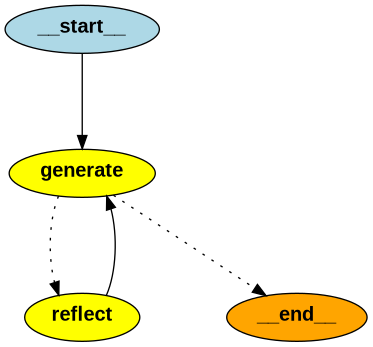

In [21]:
from IPython.display import Image, display

display(Image(workflow.get_graph().draw_png()))